In [2]:
#load all neccessary libs
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [3]:
#read  training data set
train = pd.read_csv('train.csv')
meal_info = pd.read_csv('meal_info.csv')
fullfill_info = pd.read_csv('fulfilment_center_info.csv')

In [4]:
#head of these table
train.head(5)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [5]:
meal_info.head(5)

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [6]:
meal_info['category'].unique()


array(['Beverages', 'Extras', 'Soup', 'Other Snacks', 'Salad',
       'Rice Bowl', 'Starters', 'Sandwich', 'Pasta', 'Desert', 'Biryani',
       'Pizza', 'Fish', 'Seafood'], dtype=object)

In [7]:
# I see that there is a column 'meal_id' in training set that have various values and in meal info it on ly have 14 groups of food.
# so that i will change all meal_id to this "meal_category". 
# My analysics here is want too see the relationship between meal_Category and timeline in this data set

In [8]:
fullfill_info.head(5)

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [9]:
# merge 2 data train and meal Info
new_train =  train.join(meal_info
             .set_index("meal_id")
             .loc[:, ["category"]],
             on="meal_id")

In [10]:
#new_train = new_train.drop(labels=["meal_id","center_id","emailer_for_promotion","homepage_featured"], axis=1)
new_train.head(10)

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages
1,1466964,1,55,1993,136.83,135.83,0,0,270,Beverages
2,1346989,1,55,2539,134.86,135.86,0,0,189,Beverages
3,1338232,1,55,2139,339.50,437.53,0,0,54,Beverages
4,1448490,1,55,2631,243.50,242.50,0,0,40,Beverages
5,1270037,1,55,1248,251.23,252.23,0,0,28,Beverages
6,1191377,1,55,1778,183.36,184.36,0,0,190,Beverages
7,1499955,1,55,1062,182.36,183.36,0,0,391,Beverages
8,1025244,1,55,2707,193.06,192.06,0,0,472,Beverages
9,1054194,1,55,1207,325.92,384.18,0,1,676,Beverages


In [57]:
# now we will group by same week and category for future analysic
y = new_train.groupby(["week","category"]).sum()
#y.to_frame().set_index('category')
y = y.reset_index()

# categoryList = y["category"].values
# categoryList
# y_category = []
# for category in categoryList:
#     print (category)
#     y_category[category] = y.loc[(y["category"]==category)]
#     y_category[category].set_index("week")
#     y_category[category] = y_beverages[["week","num_orders"]]

# y_category["Beverages"].head()

y_beverages = y.loc[y["category"]=="Beverages"]
y_beverages.set_index("week")
y_beverages = y_beverages[["week","num_orders"]]
y_beverages.head()

,week,num_orders
0,1,322382
12,2,381602
24,3,332159
36,4,345707
48,5,280863


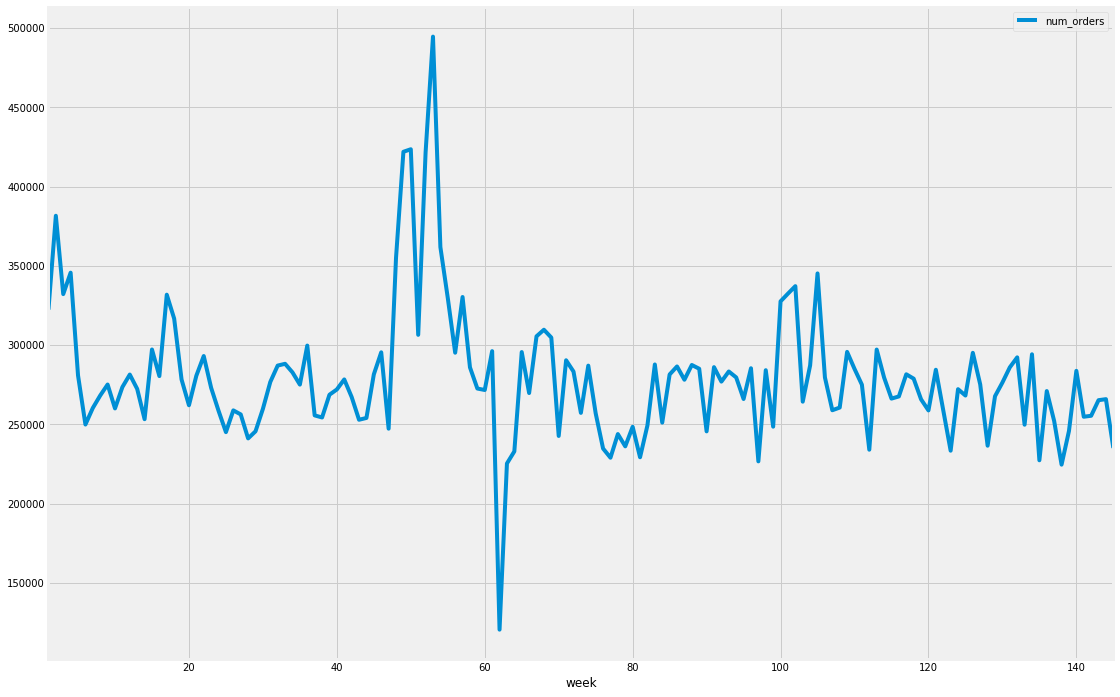

In [58]:
y_beverages.plot(x="week", y="num_orders",figsize=(17,12))  

In [59]:
y_beverages.head(5)

,week,num_orders
0,1,322382
12,2,381602
24,3,332159
36,4,345707
48,5,280863


In [60]:
def transformWeektoTS(startyear,week):
    output = (startyear + week//52) * 100 + (week % 52)
    return (str(output) + '-0')

y_beverages["week"] = y_beverages["week"].apply(lambda x: transformWeektoTS(2016,x))
y_beverages["week"] = pd.to_datetime(y_beverages["week"],format = "%Y%W-%w")




In [68]:
y_beverages = y_beverages.reset_index()
y_beverages = y_beverages.set_index("week")
y_beverages.head()

,index,num_orders
week,,
2016-01-10,0,322382
2016-01-17,12,381602
2016-01-24,24,332159
2016-01-31,36,345707
2016-02-07,48,280863


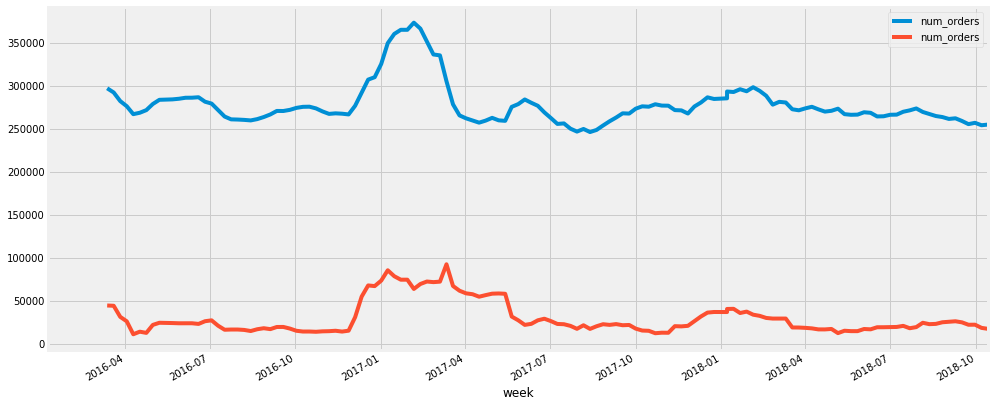

In [70]:
# Using pd.series.rolling to calculate mean and std for item_cnt_day series with window=12
# plot mean and std values
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html
# Your code here

ax = y_beverages.rolling(window=10).mean().plot(y="num_orders")
y_beverages.rolling(window=10).std().plot(y="num_orders", ax=ax)

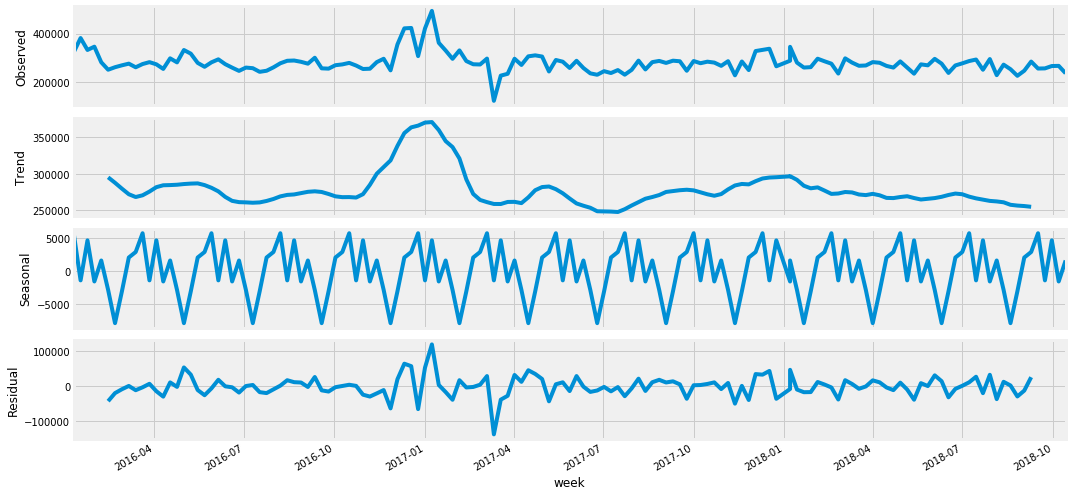

In [72]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams.update({'figure.figsize': (15,7), 'font.size': 10})
# Plot decompose diagram using seasonal_decompose
decomposition = seasonal_decompose(y_beverages["num_orders"],freq=10, model="additive")
fig = decomposition.plot();

In [73]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [79]:
# Let's test with original timeseries
test_stationarity(y_beverages["num_orders"])

Results of Dickey-Fuller Test:
Test Statistic                  -4.196896
p-value                          0.000667
#Lags Used                       5.000000
Number of Observations Used    139.000000
Critical Value (1%)             -3.478294
Critical Value (5%)             -2.882568
Critical Value (10%)            -2.577983
dtype: float64


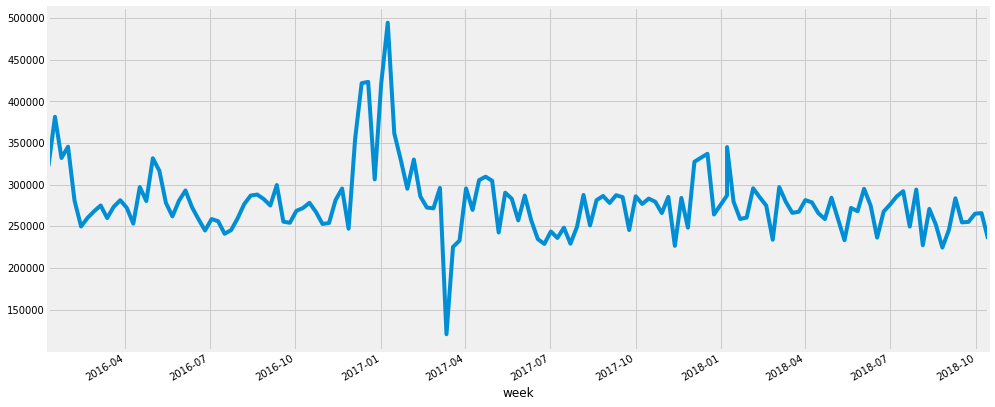

In [91]:
ts = y_beverages['num_orders']
ts.plot(y = "num_orders")

In [92]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


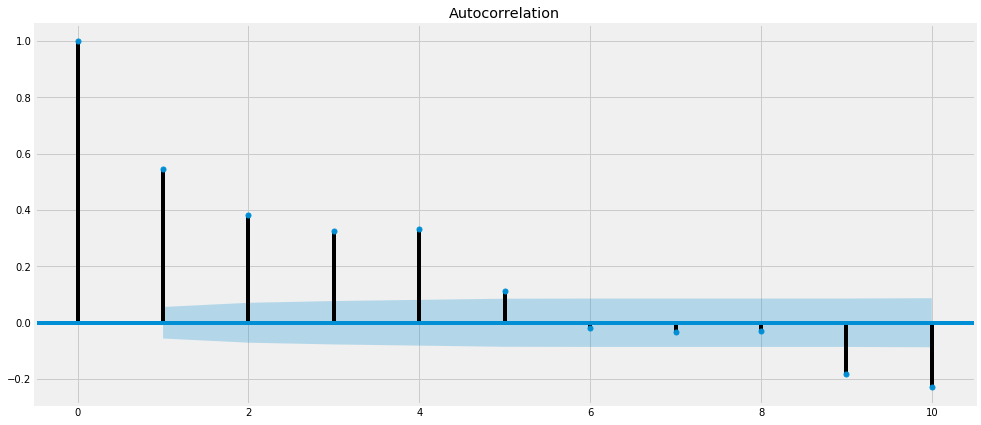

In [93]:
plot_acf(ts, lags=10, alpha=0.5);

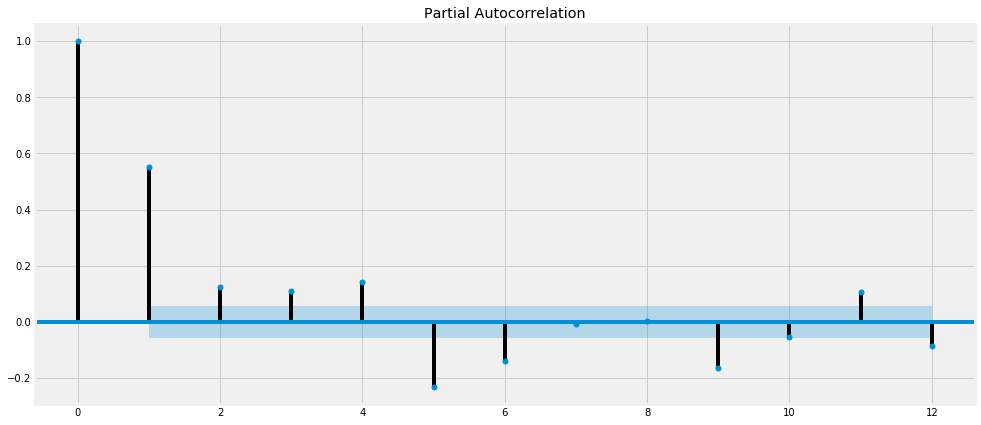

In [94]:
# Plot Partial Autocorrelation of ts with lags=12, alpha=0.5
# Your code here
plot_pacf(ts,lags=12, alpha=0.5);

In [95]:
from statsmodels.tsa.arima_model import ARMA

best_aic = np.inf
best_order = None
best_model = None

rng = range(5)
for i in rng:
    for j in rng:
        if i == j == 0:
            continue
        try:
            # Create and train ARMA model with order=(i, j)
            model = ARMA(order=(i,j)).fit()
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (i, j)
                best_model = model
        except: continue
print('AIC: {:6.5} | order: {}'.format(best_aic, best_order))

AIC:    inf | order: None


In [112]:
model =  ARMA(ts,order=(1,1)).fit()
predict = model.predict(start=0,end=144)

C:\Users\Schaefer\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


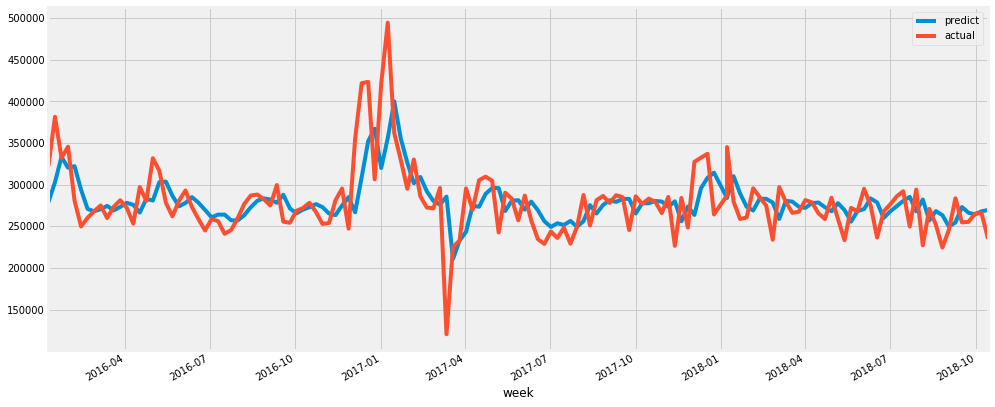

In [118]:
# Let's plot actual and predict values
# Your code here
predict.plot(label="predict")
ts.plot(label="actual")
plt.legend();

C:\Users\Schaefer\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


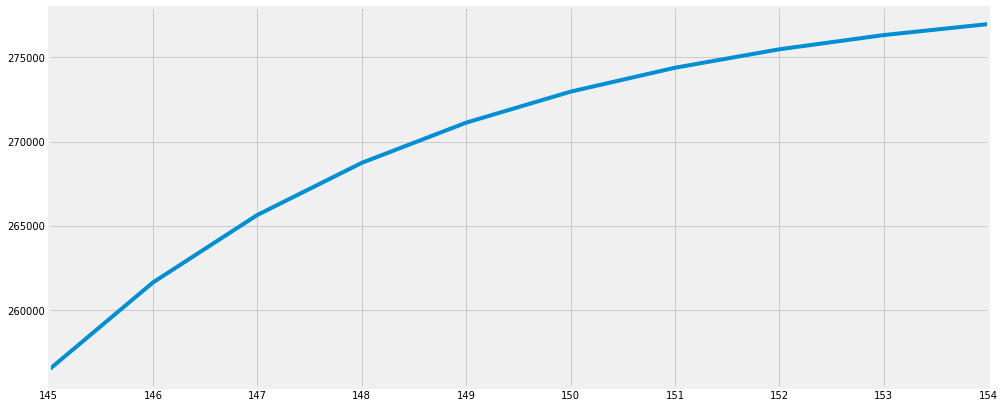

In [119]:
predict2 = model.predict(start=145,end=154)
predict2.plot(label="predict")

In [122]:
from sklearn.metrics import mean_squared_log_error
mean_squared_log_error(ts, predict)

0.015660224523224686